In [1]:
import numpy as np
import pandas as pd
import os, sys
# calculate features of small molecules
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdFreeSASA
from rdkit.Chem import MolSurf, Descriptors
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)
from utils import get_mol
from scipy.stats import pearsonr, spearmanr
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Arial'

## ESR1 (MCF7)
### Quantitative model: small-molecule properties to potency
#### calculation of features

In [2]:
# inhibitors of ESR1 (MCF7)
ESR1_MCF7_inhibitors_df = pd.read_csv('./output/Cases/ESR1_MCF7_inhibitors_info_new.csv')
ESR1_MCF7_inhibitors_df.head(2)

,Compound Name,CAS_number,smiles_code,affinity,logp,signature_similarity
0,Melatonin,73-31-4,COc1ccc2[nH]cc(CCNC(C)=O)c2c1,-6.70,1.85510,-0.205795
1,ZK-164015,177583-70-9,CCCCCS(=O)(=O)CCCCCCCCCCn1c(-c2ccc(O)cc2)c(C)c...,-9.16,7.75372,0.377206


In [3]:
# correlation between logp and signature_similarity
print(spearmanr(ESR1_MCF7_inhibitors_df.logp.tolist(), ESR1_MCF7_inhibitors_df.signature_similarity.tolist()))
print(pearsonr(ESR1_MCF7_inhibitors_df.logp.tolist(), ESR1_MCF7_inhibitors_df.signature_similarity.tolist()))

SpearmanrResult(correlation=0.6045175047765543, pvalue=0.0006563795049722675)
(0.6009580174195396, 0.000720061432696248)


In [4]:
# with open('./output/Cases/ESR1_MCF7_inhibitors.txt', 'w') as file:
#     for smi in ESR1_MCF7_inhibitors_df.smiles_code.tolist():
#         file.write(smi + '\n')

In [4]:
# 溶剂可及表面积FreeSASA
def get_freesasa(smi):
    mol = get_mol(smi)
    # add H
    mol = Chem.AddHs(mol, addCoords=True)
    # 2d to 3D
    AllChem.EmbedMolecule(mol)
    # get Van der waals radii (angstrom)
    ptable = Chem.GetPeriodicTable()
    radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in mol.GetAtoms()]
    # compute solvent accessible surface area
    sasa = rdFreeSASA.CalcSASA(mol, radii)
    return sasa


def classifyAtoms(mol, polar_atoms=[7,8,15,16]):
    #Taken from https://github.com/mittinatten/freesasa/blob/master/src/classifier.c
    symbol_radius = {"H": 1.10, "C": 1.70, "N": 1.55, "O": 1.52, "P": 1.80, "S": 1.80, "SE": 1.90,
    "F": 1.47, "CL": 1.75, "BR": 1.83, "I": 1.98,
    "LI": 1.81, "BE": 1.53, "B": 1.92,
    "NA": 2.27, "MG": 1.74, "AL": 1.84, "SI": 2.10,
    "K": 2.75, "CA": 2.31, "GA": 1.87, "GE": 2.11, "AS": 1.85,
    "RB": 3.03, "SR": 2.49, "IN": 1.93, "SN": 2.17, "SB": 2.06, "TE": 2.06}

    radii = [] 
    for atom in mol.GetAtoms():
        atom.SetProp("SASAClassName", "Apolar") # mark everything as apolar to start
        if atom.GetAtomicNum() in polar_atoms: #identify polar atoms and change their marking
            atom.SetProp("SASAClassName", "Polar") # mark as polar
        elif atom.GetAtomicNum() == 1:
            if atom.GetBonds()[0].GetOtherAtom(atom).GetAtomicNum() in polar_atoms:
                atom.SetProp("SASAClassName", "Polar") # mark as polar
        radii.append(symbol_radius[atom.GetSymbol().upper()])
    return mol, radii


def get_polar_apolar_area(smi):
    mol = get_mol(smi)
    # add H
    mol = Chem.AddHs(mol, addCoords=True)
    # 2D to 3D
    AllChem.EmbedMolecule(mol)
    # compute radii
    mol, radii = classifyAtoms(mol)
    # # get Van der waals radii (angstrom)
    # ptable = Chem.GetPeriodicTable()
    # radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in mol.GetAtoms()]
    # compute sasa
    opts = rdFreeSASA.SASAOpts()
    sasa = rdFreeSASA.CalcSASA(mol, radii, opts=opts)
    apolar = rdFreeSASA.CalcSASA(mol, radii, query=rdFreeSASA.MakeFreeSasaAPolarAtomQuery(), opts=opts)
    polar = rdFreeSASA.CalcSASA(mol, radii, query=rdFreeSASA.MakeFreeSasaPolarAtomQuery(), opts=opts)
    return sasa, polar, apolar

In [5]:
# 20 molecular properties calculated with RDKit and ADMETlab3.0

# admetlab3.0
admetlab3_res_df = pd.read_csv('./output/ADMETlab3.0/Cases/ESR1_MCF7_inhibitors_properties.csv')
# admetlab3_res_df.head(1)
ESR1_MCF7_inhibitors_df['logP1'] = [Descriptors.MolLogP(get_mol(smi)) for smi in ESR1_MCF7_inhibitors_df.smiles_code.tolist()]
ESR1_MCF7_inhibitors_df['logP2'] = admetlab3_res_df.logP.tolist()
ESR1_MCF7_inhibitors_df['logD7.4'] = admetlab3_res_df.logD.tolist()
ESR1_MCF7_inhibitors_df['logS'] = admetlab3_res_df.logS.tolist()

sasas, sasa_polars, sasa_apolars =[], [], []
for smi in ESR1_MCF7_inhibitors_df.smiles_code.tolist():
    sasa, sasa_polar, sasa_apolar = get_polar_apolar_area(smi)
    sasas.append(sasa)
    sasa_polars.append(sasa_polar)
    sasa_apolars.append(sasa_apolar)
ESR1_MCF7_inhibitors_df['sasa'] = sasas
ESR1_MCF7_inhibitors_df['sasa_polar'] = sasa_polars
ESR1_MCF7_inhibitors_df['sasa_apolar'] = sasa_apolars

ESR1_MCF7_inhibitors_df['nHD'] = [Descriptors.NumHDonors(get_mol(smi)) for smi in ESR1_MCF7_inhibitors_df.smiles_code.tolist()]
ESR1_MCF7_inhibitors_df['nHA'] = [Descriptors.NumHAcceptors(get_mol(smi)) for smi in ESR1_MCF7_inhibitors_df.smiles_code.tolist()]
ESR1_MCF7_inhibitors_df['nHE'] = [Descriptors.NumHeteroatoms(get_mol(smi)) for smi in ESR1_MCF7_inhibitors_df.smiles_code.tolist()]

ESR1_MCF7_inhibitors_df['nAroRings'] = [Descriptors.NumAromaticRings(get_mol(smi)) for smi in ESR1_MCF7_inhibitors_df.smiles_code.tolist()]
from utils import Calc_AP
ESR1_MCF7_inhibitors_df['ap'] = [Calc_AP(get_mol(smi)) for smi in ESR1_MCF7_inhibitors_df.smiles_code.tolist()]

ESR1_MCF7_inhibitors_df['TPSA'] = admetlab3_res_df.TPSA.tolist()
ESR1_MCF7_inhibitors_df['nRot'] = admetlab3_res_df.nRot.tolist()
ESR1_MCF7_inhibitors_df['Dense'] = admetlab3_res_df.Dense.tolist()
ESR1_MCF7_inhibitors_df['fChar'] = admetlab3_res_df.fChar.tolist()
ESR1_MCF7_inhibitors_df['nStereo'] = admetlab3_res_df.nStereo.tolist()
ESR1_MCF7_inhibitors_df['Fsp3'] = admetlab3_res_df.Fsp3.tolist()
ESR1_MCF7_inhibitors_df['pka_acidic'] = admetlab3_res_df.pka_acidic.tolist()
ESR1_MCF7_inhibitors_df['pka_basic'] = admetlab3_res_df.pka_basic.tolist()

In [6]:
# 20 molecular properties
features = ESR1_MCF7_inhibitors_df.columns.tolist()[-20:]
features

['logP1',
 'logP2',
 'logD7.4',
 'logS',
 'sasa',
 'sasa_polar',
 'sasa_apolar',
 'nHD',
 'nHA',
 'nHE',
 'nAroRings',
 'ap',
 'TPSA',
 'nRot',
 'Dense',
 'fChar',
 'nStereo',
 'Fsp3',
 'pka_acidic',
 'pka_basic']

#### regression model
##### random forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
fold_dict = {}
for i, (train_idx, test_idx) in enumerate(loo.split(np.arange(len(ESR1_MCF7_inhibitors_df)))):
    train_data = ESR1_MCF7_inhibitors_df.iloc[train_idx, -20:].values
    train_y = ESR1_MCF7_inhibitors_df.iloc[train_idx, -21].values
    test_data = ESR1_MCF7_inhibitors_df.iloc[test_idx, -20:].values
    test_y = ESR1_MCF7_inhibitors_df.iloc[test_idx, -21].values
    fold_dict[i] = (train_data, train_y, test_data, test_y)

In [9]:
# random forest
print('Random forest:')
impr_feats = []
# roc_data = []
preds_list = []
test_y_list = []

for i in range(len(fold_dict)):
    train_X, train_y, test_X, test_y = fold_dict[i]
    # model fit
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train_X, train_y)
    # feature importances
    impr_feat = model.feature_importances_.argsort()
    impr_feats.append(impr_feat[-5:])

    # test
    preds = model.predict(test_X)
    preds_list.append(preds[0])
    test_y_list.append(test_y[0])

print('R2', r2_score(test_y_list, preds_list))
print('PCC', pearsonr(test_y_list, preds_list))
print('Spearman', spearmanr(test_y_list, preds_list))
# print(f'ACC: {np.mean(accs):.3f} ± {np.std(accs):.3f}')
print('Importance features:')
import_feat1 = [features[impr_feat[-1]] for impr_feat in impr_feats]
import_feat2 = [features[impr_feat[-2]] for impr_feat in impr_feats]
import_feat3 = [features[impr_feat[-3]] for impr_feat in impr_feats]
import_feat4 = [features[impr_feat[-4]] for impr_feat in impr_feats]
import_feat5 = [features[impr_feat[-5]] for impr_feat in impr_feats]

print(Counter(import_feat1))
print(Counter(import_feat2))
print(Counter(import_feat3))
print(Counter(import_feat4))
print(Counter(import_feat5))

Random forest:
R2 0.1357841630490113
PCC (0.4262782468894447, 0.023699578508729096)
Spearman SpearmanrResult(correlation=0.4126984126984127, pvalue=0.029067657953807915)
Importance features:
Counter({'sasa': 20, 'logP1': 8})
Counter({'logP1': 18, 'sasa': 5, 'logS': 4, 'sasa_apolar': 1})
Counter({'logS': 17, 'sasa_apolar': 7, 'sasa': 3, 'logP1': 1})
Counter({'sasa_apolar': 17, 'logS': 6, 'pka_acidic': 2, 'sasa_polar': 1, 'logP1': 1, 'logP2': 1})
Counter({'pka_acidic': 19, 'nRot': 4, 'logP2': 3, 'sasa_polar': 1, 'sasa_apolar': 1})


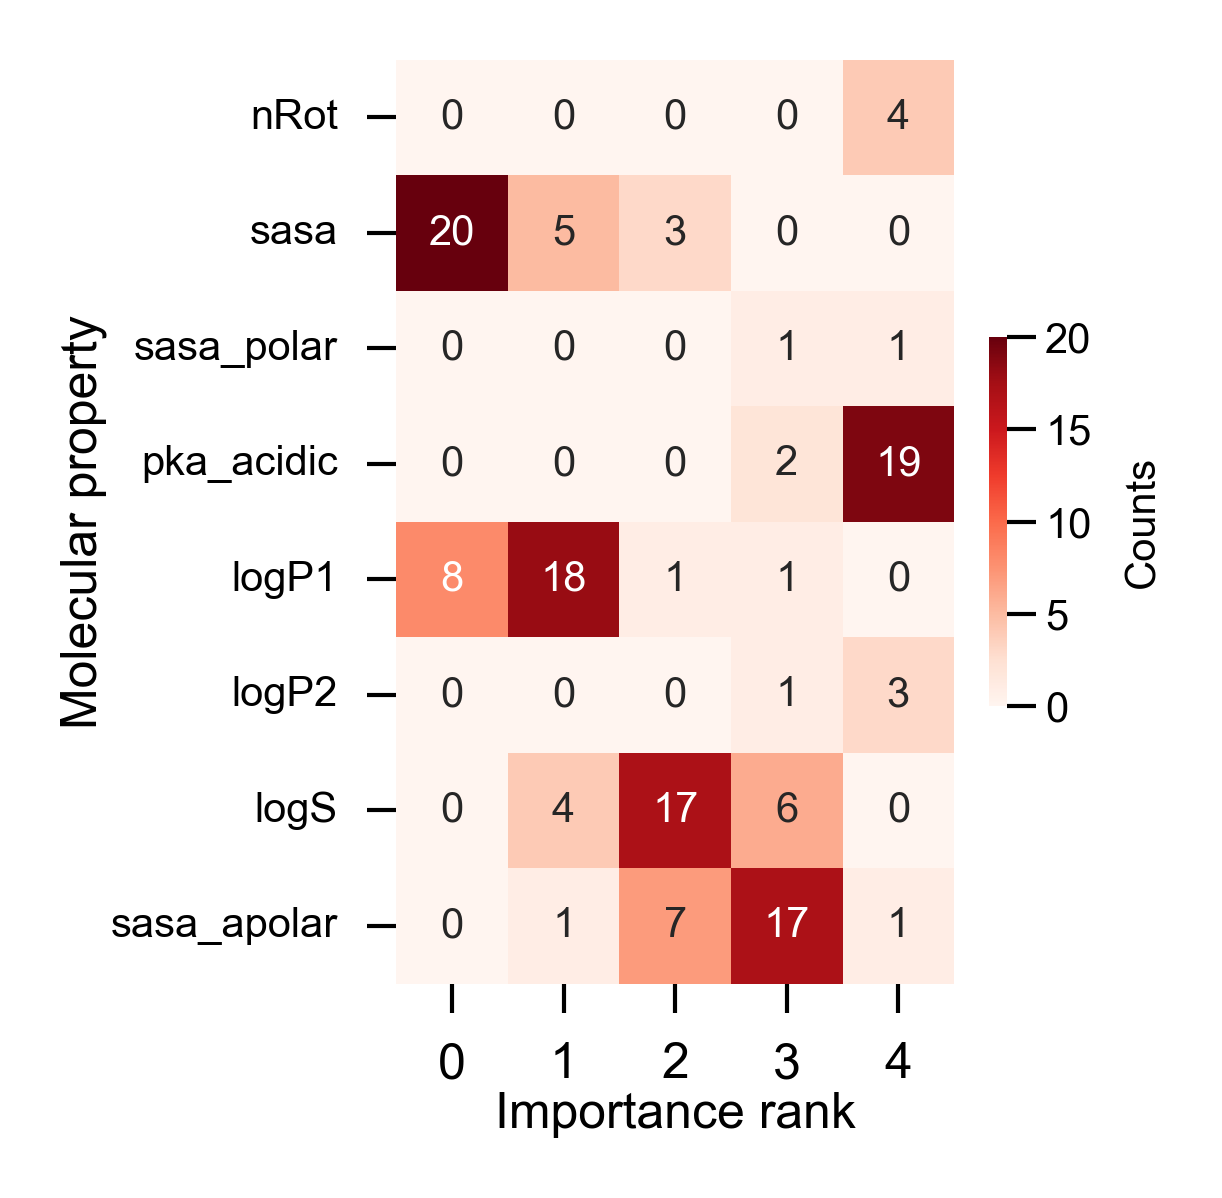

In [10]:
import_feat_unique = set(import_feat1 + import_feat2 + import_feat3 + import_feat4 + import_feat5)
import_feat_df = pd.DataFrame({
    0: [0.] * len(import_feat_unique),
    1: [0.] * len(import_feat_unique),
    2: [0.] * len(import_feat_unique),
    3: [0.] * len(import_feat_unique),
    4: [0.] * len(import_feat_unique),
}, index=list(import_feat_unique))
for feat in import_feat_unique:
    import_feat_df.loc[feat, 0] = import_feat1.count(feat)
    import_feat_df.loc[feat, 1] = import_feat2.count(feat)
    import_feat_df.loc[feat, 2] = import_feat3.count(feat)
    import_feat_df.loc[feat, 3] = import_feat4.count(feat)
    import_feat_df.loc[feat, 4] = import_feat5.count(feat)

fig, ax = plt.subplots(1, 1, figsize=(1.5,2.), dpi=600)
sns.heatmap(data=import_feat_df, ax=ax, cmap='Reds', annot=True, annot_kws={'fontsize': 5}, 
            cbar=True, cbar_kws={'shrink': 0.4})
ax.tick_params(width=0.5)
ax.set_xticklabels(import_feat_df.columns.tolist(), rotation=0, fontsize=6)
ax.set_yticklabels(import_feat_df.index.tolist(), fontsize=5)
ax.set_xlabel('Importance rank', fontsize=6, labelpad=0.5)
ax.set_ylabel('Molecular property', fontsize=6, labelpad=0.5)
# set cbar
cbar = ax.collections[0].colorbar
cbar.set_label('Counts', fontsize=5)
cbar.ax.tick_params(labelsize=5, width=0.5, pad=1)
plt.savefig('./output/figures/ESR1_MCF7_regressor_feat_importances.png', dpi=600, bbox_inches="tight")
plt.show()

In [13]:
print(spearmanr(ESR1_MCF7_inhibitors_df.logP1.tolist(), ESR1_MCF7_inhibitors_df.sasa.tolist()))
print(spearmanr(ESR1_MCF7_inhibitors_df.logP1.tolist(), ESR1_MCF7_inhibitors_df.sasa_apolar.tolist()))
print(spearmanr(ESR1_MCF7_inhibitors_df.logP1.tolist(), ESR1_MCF7_inhibitors_df.sasa_polar.tolist()))

# logp1 与 sasa (sasa_apolar) 之间存在多重共线性
print(spearmanr(ESR1_MCF7_inhibitors_df.signature_similarity.tolist(), ESR1_MCF7_inhibitors_df.sasa_apolar.tolist()))

print(spearmanr(ESR1_MCF7_inhibitors_df.signature_similarity.tolist(), ESR1_MCF7_inhibitors_df.pka_acidic.tolist()))
print(spearmanr(ESR1_MCF7_inhibitors_df.logp.tolist(), ESR1_MCF7_inhibitors_df.pka_acidic.tolist()))

SpearmanrResult(correlation=0.865982276996486, pvalue=2.646299362437826e-09)
SpearmanrResult(correlation=0.8689939131162967, pvalue=2.0047125528018437e-09)
SpearmanrResult(correlation=-0.30143739708287426, pvalue=0.11903264980544014)
SpearmanrResult(correlation=0.588943623426382, pvalue=0.0009765605897552657)
SpearmanrResult(correlation=0.33004926108374383, pvalue=0.08629505356382869)
SpearmanrResult(correlation=0.3619439045808898, pvalue=0.05840465209365018)


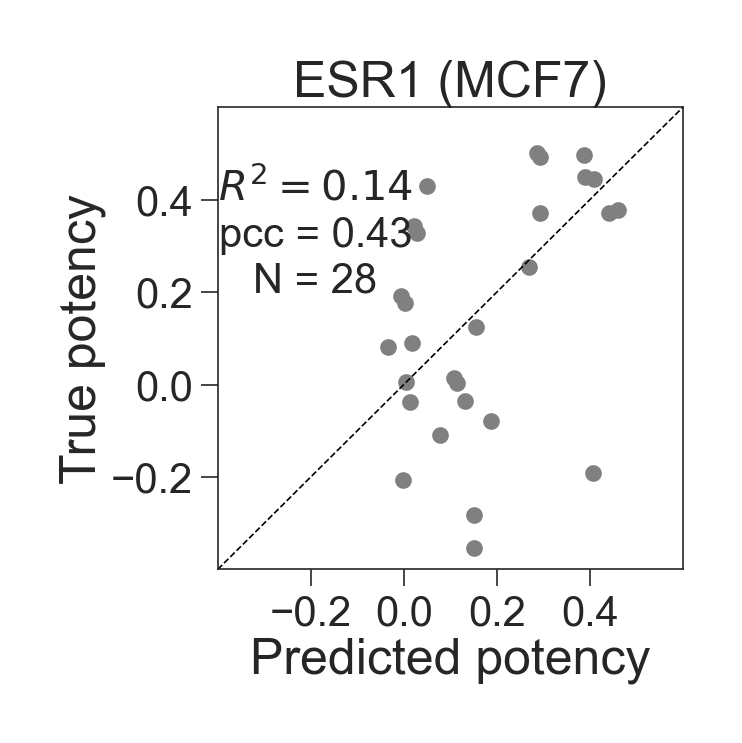

In [12]:
sns.set_style('ticks')
# sns.set_context("paper", rc={"grid.linewidth": 0.3})
fig, ax = plt.subplots(1 ,1, figsize=(1.,1.), dpi=600)
ax.set_title(f'ESR1 (MCF7)', fontsize=6, pad=0.5)
ax.scatter(preds_list, test_y_list, c='grey', s=1)
ax.text(-0.19, 0.4, f'$R^2 = 0.14$', fontsize=5, ha='center')
ax.text(-0.19, 0.3, f'pcc = 0.43', fontsize=5, ha='center')
ax.text(-0.19, 0.2, f'N = 28', fontsize=5, ha='center')

ax.set_xlim(-0.4, 0.6)
ax.set_ylim(-0.4, 0.6)
ax.set_yticks([-0.2, 0, 0.2, 0.4])
ax.set_xticks([-0.2, 0, 0.2, 0.4])
ax.tick_params(labelsize=5, width=0.2, length=2, pad=1)
ax.spines['bottom'].set_linewidth(0.2)
ax.spines['top'].set_linewidth(0.2)
ax.spines['left'].set_linewidth(0.2)
ax.spines['right'].set_linewidth(0.2)
plt.xlabel('Predicted potency', fontsize=6, labelpad=0.5)
plt.ylabel('True potency', fontsize=6, labelpad=0.5)

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]], 
        linestyle='--', linewidth=0.2, color='black')
# legend = ax.legend(loc='lower right', fontsize=5, frameon=True, labelspacing=0.1, handletextpad=0.1, borderpad=0.2)
# legend.get_frame().set_linewidth(0.2)
plt.savefig('./output/figures/ESR1_MCF7_regressor_scatterplot.pdf', dpi=600, bbox_inches="tight")
plt.savefig('./output/figures/ESR1_MCF7_regressor_scatterplot.png', dpi=600, bbox_inches="tight")

plt.show()

## EGFR (HCC515)
### Quantitative model: small-molecule properties to potency
#### calculation of features

In [14]:
EGFR_HCC515_inhibitors_df = pd.read_csv('./output/Cases/EGFR_HCC515_inhibitors.csv')
EGFR_HCC515_inhibitors_df.head(1)

,smiles_code,logp,signature_similarity
0,CCCCCCCCN[C@H](C)[C@@H](O)c1ccc(SC(C)C)cc1,5.5591,0.105587


In [15]:
# correlation between logp and signature_similarity
print(spearmanr(EGFR_HCC515_inhibitors_df.logp.tolist(), EGFR_HCC515_inhibitors_df.signature_similarity.tolist()))
print(pearsonr(EGFR_HCC515_inhibitors_df.logp.tolist(), EGFR_HCC515_inhibitors_df.signature_similarity.tolist()))

SpearmanrResult(correlation=0.45266460893833843, pvalue=0.0010918331394418662)
(0.45577785759575073, 0.0009982808900709749)


In [16]:
# with open('./output/Cases/EGFR_HCC515_inhibitors.txt', 'w') as file:
#     for smi in EGFR_HCC515_inhibitors_df.smiles_code.tolist():
#         file.write(smi + '\n')

In [16]:
# 20 molecular properties calculated with RDKit and ADMETlab3.0

# admetlab3.0
admetlab3_res_df = pd.read_csv('./output/ADMETlab3.0/Cases/EGFR_HCC515_inhibitors_properties.csv')
# admetlab3_res_df.head(1)
EGFR_HCC515_inhibitors_df['logP1'] = [Descriptors.MolLogP(get_mol(smi)) for smi in EGFR_HCC515_inhibitors_df.smiles_code.tolist()]
EGFR_HCC515_inhibitors_df['logP2'] = admetlab3_res_df.logP.tolist()
EGFR_HCC515_inhibitors_df['logD7.4'] = admetlab3_res_df.logD.tolist()
EGFR_HCC515_inhibitors_df['logS'] = admetlab3_res_df.logS.tolist()

sasas, sasa_polars, sasa_apolars =[], [], []
for smi in EGFR_HCC515_inhibitors_df.smiles_code.tolist():
    sasa, sasa_polar, sasa_apolar = get_polar_apolar_area(smi)
    sasas.append(sasa)
    sasa_polars.append(sasa_polar)
    sasa_apolars.append(sasa_apolar)
EGFR_HCC515_inhibitors_df['sasa'] = sasas
EGFR_HCC515_inhibitors_df['sasa_polar'] = sasa_polars
EGFR_HCC515_inhibitors_df['sasa_apolar'] = sasa_apolars

EGFR_HCC515_inhibitors_df['nHD'] = [Descriptors.NumHDonors(get_mol(smi)) for smi in EGFR_HCC515_inhibitors_df.smiles_code.tolist()]
EGFR_HCC515_inhibitors_df['nHA'] = [Descriptors.NumHAcceptors(get_mol(smi)) for smi in EGFR_HCC515_inhibitors_df.smiles_code.tolist()]
EGFR_HCC515_inhibitors_df['nHE'] = [Descriptors.NumHeteroatoms(get_mol(smi)) for smi in EGFR_HCC515_inhibitors_df.smiles_code.tolist()]

EGFR_HCC515_inhibitors_df['nAroRings'] = [Descriptors.NumAromaticRings(get_mol(smi)) for smi in EGFR_HCC515_inhibitors_df.smiles_code.tolist()]
from utils import Calc_AP
EGFR_HCC515_inhibitors_df['ap'] = [Calc_AP(get_mol(smi)) for smi in EGFR_HCC515_inhibitors_df.smiles_code.tolist()]

EGFR_HCC515_inhibitors_df['TPSA'] = admetlab3_res_df.TPSA.tolist()
EGFR_HCC515_inhibitors_df['nRot'] = admetlab3_res_df.nRot.tolist()
EGFR_HCC515_inhibitors_df['Dense'] = admetlab3_res_df.Dense.tolist()
EGFR_HCC515_inhibitors_df['fChar'] = admetlab3_res_df.fChar.tolist()
EGFR_HCC515_inhibitors_df['nStereo'] = admetlab3_res_df.nStereo.tolist()
EGFR_HCC515_inhibitors_df['Fsp3'] = admetlab3_res_df.Fsp3.tolist()
EGFR_HCC515_inhibitors_df['pka_acidic'] = admetlab3_res_df.pka_acidic.tolist()
EGFR_HCC515_inhibitors_df['pka_basic'] = admetlab3_res_df.pka_basic.tolist()

#### regression model
##### ranfom forest

In [17]:
loo = LeaveOneOut()
fold_dict = {}
for i, (train_idx, test_idx) in enumerate(loo.split(np.arange(len(EGFR_HCC515_inhibitors_df)))):
    train_data = EGFR_HCC515_inhibitors_df.iloc[train_idx, -20:].values
    train_y = EGFR_HCC515_inhibitors_df.iloc[train_idx, -21].values
    test_data = EGFR_HCC515_inhibitors_df.iloc[test_idx, -20:].values
    test_y = EGFR_HCC515_inhibitors_df.iloc[test_idx, -21].values
    fold_dict[i] = (train_data, train_y, test_data, test_y)

In [18]:
# random forest
print('Random forest:')
impr_feats = []
# roc_data = []
preds_list = []
test_y_list = []

for i in range(len(fold_dict)):
    train_X, train_y, test_X, test_y = fold_dict[i]
    # model fit
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train_X, train_y)
    # feature importances
    impr_feat = model.feature_importances_.argsort()
    impr_feats.append(impr_feat[-5:])

    # test
    preds = model.predict(test_X)
    preds_list.append(preds[0])
    test_y_list.append(test_y[0])

print('R2', r2_score(test_y_list, preds_list))
print('PCC', pearsonr(test_y_list, preds_list))
print('Spearman', spearmanr(test_y_list, preds_list))
# print(f'ACC: {np.mean(accs):.3f} ± {np.std(accs):.3f}')
print('Importance features:')
import_feat1 = [features[impr_feat[-1]] for impr_feat in impr_feats]
import_feat2 = [features[impr_feat[-2]] for impr_feat in impr_feats]
import_feat3 = [features[impr_feat[-3]] for impr_feat in impr_feats]
import_feat4 = [features[impr_feat[-4]] for impr_feat in impr_feats]
import_feat5 = [features[impr_feat[-5]] for impr_feat in impr_feats]

print(Counter(import_feat1))
print(Counter(import_feat2))
print(Counter(import_feat3))
print(Counter(import_feat4))
print(Counter(import_feat5))

Random forest:
R2 0.2889463399930452
PCC (0.5453940561163596, 5.067358336739528e-05)
Spearman SpearmanrResult(correlation=0.4777551020408163, pvalue=0.0005175387949793055)
Importance features:
Counter({'sasa_polar': 42, 'logD7.4': 7})
Counter({'logD7.4': 39, 'pka_acidic': 5, 'sasa_polar': 5})
Counter({'pka_acidic': 43, 'sasa_polar': 2, 'logD7.4': 2, 'sasa_apolar': 2})
Counter({'sasa_apolar': 28, 'logS': 6, 'pka_basic': 6, 'ap': 5, 'logP1': 1, 'Dense': 1, 'logP2': 1, 'pka_acidic': 1})
Counter({'logS': 13, 'ap': 10, 'sasa_apolar': 9, 'pka_basic': 7, 'logP1': 4, 'nRot': 3, 'Dense': 2, 'logD7.4': 1})


In [18]:
# print(spearmanr(EGFR_HCC515_inhibitors_df.logp1.tolist(), EGFR_HCC515_inhibitors_df.sasa.tolist()))
# print(spearmanr(EGFR_HCC515_inhibitors_df.logp1.tolist(), EGFR_HCC515_inhibitors_df.sasa_apolar.tolist()))
# print(spearmanr(EGFR_HCC515_inhibitors_df.logp1.tolist(), EGFR_HCC515_inhibitors_df.sasa_polar.tolist()))

# # logp1 与 sasa (sasa_apolar) 之间存在多重共线性
# print(spearmanr(EGFR_HCC515_inhibitors_df.signature_similarity.tolist(), EGFR_HCC515_inhibitors_df.sasa_apolar.tolist()))
# print(spearmanr(EGFR_HCC515_inhibitors_df.signature_similarity.tolist(), EGFR_HCC515_inhibitors_df.sasa_polar.tolist()))

# print(spearmanr(EGFR_HCC515_inhibitors_df.signature_similarity.tolist(), EGFR_HCC515_inhibitors_df.pka_acidic.tolist()))

SpearmanrResult(correlation=0.7068037452234899, pvalue=1.381459172284415e-08)
SpearmanrResult(correlation=0.8508890535690566, pvalue=9.801740838739273e-15)
SpearmanrResult(correlation=-0.5651674789461199, pvalue=2.3276463963392867e-05)
SpearmanrResult(correlation=0.4681632653061224, pvalue=0.0006931150430368234)
SpearmanrResult(correlation=-0.5180612244897959, pvalue=0.0001374812507150394)
SpearmanrResult(correlation=0.48377551020408155, pvalue=0.0004289484911413996)


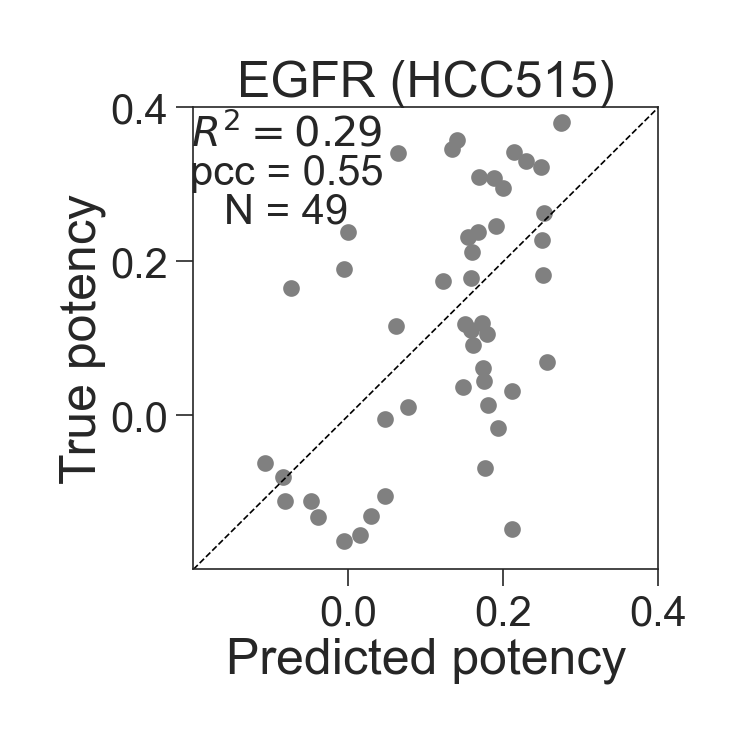

In [19]:
sns.set_style('ticks')
# sns.set_context("paper", rc={"grid.linewidth": 0.3})
fig, ax = plt.subplots(1 ,1, figsize=(1.,1.), dpi=600)
ax.set_title(f'EGFR (HCC515)', fontsize=6, pad=0.5)
ax.scatter(preds_list, test_y_list, c='grey', s=1)
ax.text(-0.08, 0.35, f'$R^2 = 0.29$', fontsize=5, ha='center')
ax.text(-0.08, 0.3, f'pcc = 0.55', fontsize=5, ha='center')
ax.text(-0.08, 0.25, f'N = 49', fontsize=5, ha='center')

ax.set_xlim(-0.2, 0.4)
ax.set_ylim(-0.2, 0.4)
ax.set_yticks([0, 0.2, 0.4])
ax.set_xticks([0, 0.2, 0.4])
ax.tick_params(labelsize=5, width=0.2, length=2, pad=1)
ax.spines['bottom'].set_linewidth(0.2)
ax.spines['top'].set_linewidth(0.2)
ax.spines['left'].set_linewidth(0.2)
ax.spines['right'].set_linewidth(0.2)
plt.xlabel('Predicted potency', fontsize=6, labelpad=0.5)
plt.ylabel('True potency', fontsize=6, labelpad=0.5)

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]], 
        linestyle='--', linewidth=0.2, color='black')
# legend = ax.legend(loc='lower right', fontsize=5, frameon=True, labelspacing=0.1, handletextpad=0.1, borderpad=0.2)
# legend.get_frame().set_linewidth(0.2)
plt.savefig('./output/figures/EGFR_HCC515_regressor_scatterplot.pdf', dpi=600, bbox_inches="tight")
plt.savefig('./output/figures/EGFR_HCC515_regressor_scatterplot.png', dpi=600, bbox_inches="tight")

plt.show()

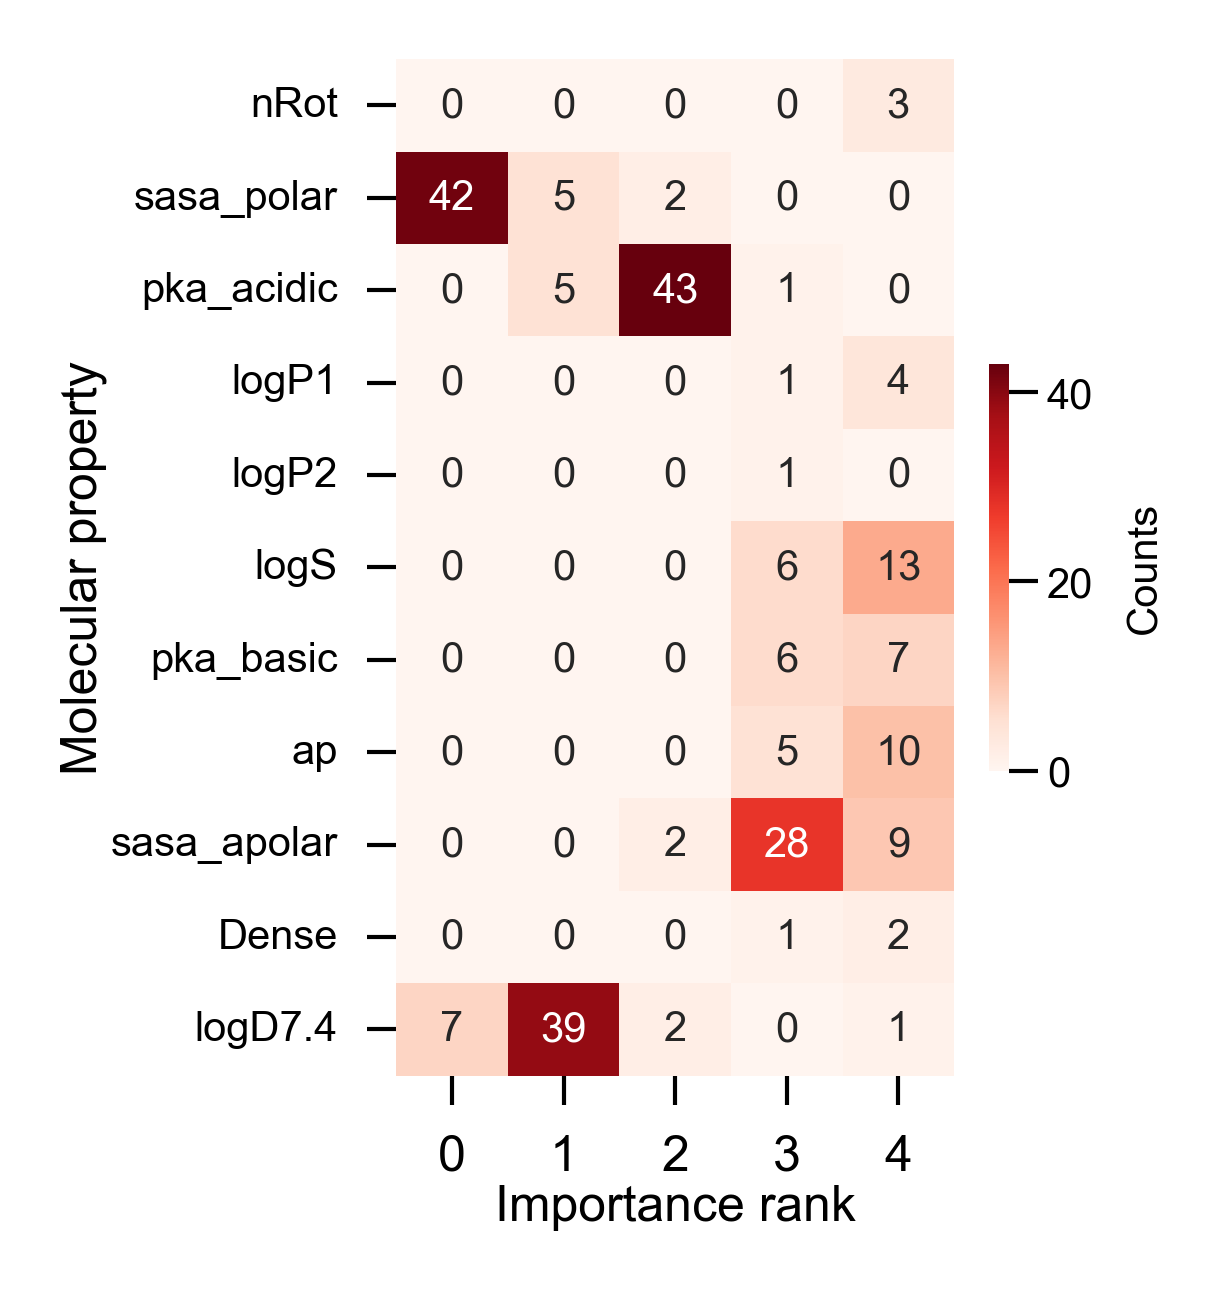

In [19]:
import_feat_unique = set(import_feat1 + import_feat2 + import_feat3 + import_feat4 + import_feat5)
import_feat_df = pd.DataFrame({
    0: [0.] * len(import_feat_unique),
    1: [0.] * len(import_feat_unique),
    2: [0.] * len(import_feat_unique),
    3: [0.] * len(import_feat_unique),
    4: [0.] * len(import_feat_unique),
}, index=list(import_feat_unique))
for feat in import_feat_unique:
    import_feat_df.loc[feat, 0] = import_feat1.count(feat)
    import_feat_df.loc[feat, 1] = import_feat2.count(feat)
    import_feat_df.loc[feat, 2] = import_feat3.count(feat)
    import_feat_df.loc[feat, 3] = import_feat4.count(feat)
    import_feat_df.loc[feat, 4] = import_feat5.count(feat)

fig, ax = plt.subplots(1, 1, figsize=(1.5,2.2), dpi=600)
sns.heatmap(data=import_feat_df, ax=ax, cmap='Reds', annot=True, annot_kws={'fontsize': 5}, 
            cbar=True, cbar_kws={'shrink': 0.4})
ax.tick_params(width=0.5)
ax.set_xticklabels(import_feat_df.columns.tolist(), rotation=0, fontsize=6)
ax.set_yticklabels(import_feat_df.index.tolist(), fontsize=5)
ax.set_xlabel('Importance rank', fontsize=6, labelpad=0.5)
ax.set_ylabel('Molecular property', fontsize=6, labelpad=0.5)
# set cbar
cbar = ax.collections[0].colorbar
cbar.set_label('Counts', fontsize=5)
cbar.ax.tick_params(labelsize=5, width=0.5, pad=1)
plt.savefig('./output/figures/EGFR_HCC515_regressor_feat_importances.png', dpi=600, bbox_inches="tight")

plt.show()

### EGFR (HCC515): using EGFR (PC3) as test set

In [21]:
EGFR_PC3_inhibitors_df = pd.read_csv('./output/Cases/EGFR_PC3_inhibitors.csv')
EGFR_PC3_inhibitors_df.head(1)

,smiles_code,logp,signature_similarity
0,CCCCCCCCN[C@H](C)[C@@H](O)c1ccc(SC(C)C)cc1,5.5591,0.138025


In [22]:
# correlation between logp and signature_similarity
print(spearmanr(EGFR_PC3_inhibitors_df.logp.tolist(), EGFR_PC3_inhibitors_df.signature_similarity.tolist()))
print(pearsonr(EGFR_PC3_inhibitors_df.logp.tolist(), EGFR_PC3_inhibitors_df.signature_similarity.tolist()))

SpearmanrResult(correlation=0.2975761380814207, pvalue=0.005977076125933776)
(0.29719764759399087, 0.0060442204871903596)


In [35]:
# with open('./output/Cases/EGFR_PC3_inhibitors.txt', 'w') as file:
#     for smi in EGFR_PC3_inhibitors_df.smiles_code.tolist():
#         file.write(smi + '\n')

In [23]:
# 20 molecular properties calculated with RDKit and ADMETlab3.0

# admetlab3.0
admetlab3_res_df = pd.read_csv('./output/ADMETlab3.0/Cases/EGFR_PC3_inhibitors_properties.csv')
# admetlab3_res_df.head(1)
EGFR_PC3_inhibitors_df['logp1'] = [Descriptors.MolLogP(get_mol(smi)) for smi in EGFR_PC3_inhibitors_df.smiles_code.tolist()]
EGFR_PC3_inhibitors_df['logp2'] = admetlab3_res_df.logP.tolist()
EGFR_PC3_inhibitors_df['logD7.4'] = admetlab3_res_df.logD.tolist()
EGFR_PC3_inhibitors_df['logS'] = admetlab3_res_df.logS.tolist()

sasas, sasa_polars, sasa_apolars =[], [], []
for smi in EGFR_PC3_inhibitors_df.smiles_code.tolist():
    sasa, sasa_polar, sasa_apolar = get_polar_apolar_area(smi)
    sasas.append(sasa)
    sasa_polars.append(sasa_polar)
    sasa_apolars.append(sasa_apolar)
EGFR_PC3_inhibitors_df['sasa'] = sasas
EGFR_PC3_inhibitors_df['sasa_polar'] = sasa_polars
EGFR_PC3_inhibitors_df['sasa_apolar'] = sasa_apolars

EGFR_PC3_inhibitors_df['nHD'] = [Descriptors.NumHDonors(get_mol(smi)) for smi in EGFR_PC3_inhibitors_df.smiles_code.tolist()]
EGFR_PC3_inhibitors_df['nHA'] = [Descriptors.NumHAcceptors(get_mol(smi)) for smi in EGFR_PC3_inhibitors_df.smiles_code.tolist()]
EGFR_PC3_inhibitors_df['nHE'] = [Descriptors.NumHeteroatoms(get_mol(smi)) for smi in EGFR_PC3_inhibitors_df.smiles_code.tolist()]

EGFR_PC3_inhibitors_df['nAroRings'] = [Descriptors.NumAromaticRings(get_mol(smi)) for smi in EGFR_PC3_inhibitors_df.smiles_code.tolist()]
from utils import Calc_AP
EGFR_PC3_inhibitors_df['ap'] = [Calc_AP(get_mol(smi)) for smi in EGFR_PC3_inhibitors_df.smiles_code.tolist()]

EGFR_PC3_inhibitors_df['TPSA'] = admetlab3_res_df.TPSA.tolist()
EGFR_PC3_inhibitors_df['nRot'] = admetlab3_res_df.nRot.tolist()
EGFR_PC3_inhibitors_df['Dense'] = admetlab3_res_df.Dense.tolist()
EGFR_PC3_inhibitors_df['fChar'] = admetlab3_res_df.fChar.tolist()
EGFR_PC3_inhibitors_df['nStereo'] = admetlab3_res_df.nStereo.tolist()
EGFR_PC3_inhibitors_df['Fsp3'] = admetlab3_res_df.Fsp3.tolist()
EGFR_PC3_inhibitors_df['pka_acidic'] = admetlab3_res_df.pka_acidic.tolist()
EGFR_PC3_inhibitors_df['pka_basic'] = admetlab3_res_df.pka_basic.tolist()

In [24]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(EGFR_HCC515_inhibitors_df.iloc[:, -20:].values, EGFR_HCC515_inhibitors_df.iloc[:, -21].values)
preds = model.predict(EGFR_PC3_inhibitors_df.iloc[:, -20:].values)
print(r2_score(EGFR_PC3_inhibitors_df.iloc[:, -21].values, preds))
print(spearmanr(EGFR_PC3_inhibitors_df.iloc[:, -21].values, preds))
print(pearsonr(EGFR_PC3_inhibitors_df.iloc[:, -21].values, preds))

-3.349680653521915
SpearmanrResult(correlation=0.39495798319327735, pvalue=0.00020083086136230612)
(0.42328815037754525, 6.029031830498605e-05)


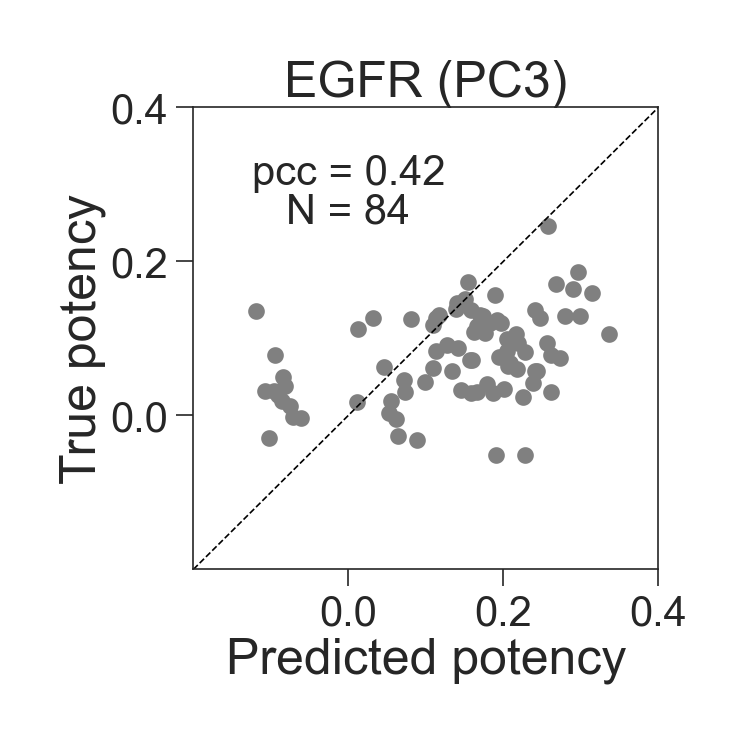

In [25]:
sns.set_style('ticks')
# sns.set_context("paper", rc={"grid.linewidth": 0.3})
fig, ax = plt.subplots(1 ,1, figsize=(1.,1.), dpi=600)
ax.set_title(f'EGFR (PC3)', fontsize=6, pad=0.5)
ax.scatter(preds, EGFR_PC3_inhibitors_df.iloc[:, -21].values, c='grey', s=1)
# ax.text(-0.08, 0.35, f'$R^2 = 0.29$', fontsize=5, ha='center')
ax.text(-0., 0.3, f'pcc = 0.42', fontsize=5, ha='center')
ax.text(-0., 0.25, f'N = 84', fontsize=5, ha='center')

ax.set_xlim(-0.2, 0.4)
ax.set_ylim(-0.2, 0.4)
ax.set_yticks([0, 0.2, 0.4])
ax.set_xticks([0, 0.2, 0.4])
ax.tick_params(labelsize=5, width=0.2, length=2, pad=1)
ax.spines['bottom'].set_linewidth(0.2)
ax.spines['top'].set_linewidth(0.2)
ax.spines['left'].set_linewidth(0.2)
ax.spines['right'].set_linewidth(0.2)
plt.xlabel('Predicted potency', fontsize=6, labelpad=0.5)
plt.ylabel('True potency', fontsize=6, labelpad=0.5)

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]], 
        linestyle='--', linewidth=0.2, color='black')
# legend = ax.legend(loc='lower right', fontsize=5, frameon=True, labelspacing=0.1, handletextpad=0.1, borderpad=0.2)
# legend.get_frame().set_linewidth(0.2)
plt.savefig('./output/figures/EGFR_PC3_regressor_scatterplot.pdf', dpi=600, bbox_inches="tight")
plt.savefig('./output/figures/EGFR_PC3_regressor_scatterplot.png', dpi=600, bbox_inches="tight")

plt.show()